# Notebook 4: Model Training

In [1]:
# !pip install timm
# !pip install tensorboard
# !pip install --upgrade ipywidgets jupyter
import warnings
warnings.filterwarnings("ignore")


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import timm
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import log_loss, accuracy_score

import pandas as pd
import numpy as np
from pathlib import Path
from tqdm.notebook import tqdm
import json
import time
from datetime import datetime
import matplotlib.pyplot as plt

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"Device: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.8.0
CUDA available: False


In [3]:
# Paths
OUTPUT_DIR = Path("outputs")
MODELS_DIR = OUTPUT_DIR / "models"
LOGS_DIR = OUTPUT_DIR / "logs"
MODELS_DIR.mkdir(exist_ok=True)
LOGS_DIR.mkdir(exist_ok=True)

# Training config
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
NUM_CLASSES = 8
NUM_EPOCHS = 12
EARLY_STOPPING_PATIENCE = 6

print(f"Device: {DEVICE}")
print(f"Number of classes: {NUM_CLASSES}")
print(f"Number of epochs: {NUM_EPOCHS}")

Device: cpu
Number of classes: 8
Number of epochs: 12


In [4]:
class ResNet50Model(nn.Module):
    """ResNet50 with custom classifier"""
    
    def __init__(self, num_classes=8, pretrained=True, dropout=0.5):
        super(ResNet50Model, self).__init__()
        
        # Load pretrained ResNet50
        self.backbone = models.resnet50(pretrained=pretrained)
        
        # Replace final layer
        num_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(num_features, num_classes)
        )
        
        self.model_name = "ResNet50"
    
    def forward(self, x):
        return self.backbone(x)


class EfficientNetModel(nn.Module):
    """EfficientNet with custom classifier"""
    
    def __init__(self, model_name='efficientnet_b0', num_classes=8, pretrained=True, dropout=0.5):
        super(EfficientNetModel, self).__init__()
        
        # Load pretrained EfficientNet
        self.backbone = timm.create_model(
            model_name,
            pretrained=pretrained,
            num_classes=num_classes,
            drop_rate=dropout
        )
        
        self.model_name = model_name
    
    def forward(self, x):
        return self.backbone(x)


def create_model(
    model_type='resnet50',
    num_classes=8,
    pretrained=True,
    dropout=0.5,
    freeze_backbone=True
):
    """Factory function to create models with optional backbone freezing"""

    if model_type == 'resnet50':
        model = ResNet50Model(num_classes, pretrained, dropout)

        if freeze_backbone:
            # Freeze entire backbone
            for param in model.backbone.parameters():
                param.requires_grad = False

            # Unfreeze classifier head only
            for param in model.backbone.fc.parameters():
                param.requires_grad = True

    elif model_type.startswith('efficientnet'):
        model = EfficientNetModel(model_type, num_classes, pretrained, dropout)

        if freeze_backbone:
            # Freeze entire backbone
            for param in model.backbone.parameters():
                param.requires_grad = False

            # Unfreeze EfficientNet classifier
            for param in model.backbone.classifier.parameters():
                param.requires_grad = True

    else:
        raise ValueError(f"Unknown model type: {model_type}")

    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print(f" Model: {model_type}")
    print(f"   Total parameters: {total_params:,}")
    print(f"   Trainable parameters: {trainable_params:,}")

    return model


# Test model creation
test_model = create_model('resnet50', NUM_CLASSES)
print(f"\n Model architecture ready")
del test_model  # Free memory

 Model: resnet50
   Total parameters: 23,524,424
   Trainable parameters: 16,392

 Model architecture ready


In [5]:
class WeightedBCEWithLogitsLoss(nn.Module):
    """Weighted Binary Cross Entropy Loss"""
    
    def __init__(self, class_weights=None):
        super(WeightedBCEWithLogitsLoss, self).__init__()
        self.class_weights = class_weights
    
    def forward(self, logits, targets):
        probs = torch.sigmoid(logits)
        
        loss = -(targets * torch.log(probs + 1e-7) + 
                 (1 - targets) * torch.log(1 - probs + 1e-7))
        
        if self.class_weights is not None:
            if self.class_weights.device != loss.device:
                self.class_weights = self.class_weights.to(loss.device)
            loss = loss * self.class_weights.unsqueeze(0)
        
        return loss.mean()


class FocalLoss(nn.Module):
    """Focal Loss for handling hard examples"""
    
    def __init__(self, alpha=0.25, gamma=2.0):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
    
    def forward(self, logits, targets):
        probs = torch.sigmoid(logits)
        ce_loss = -(targets * torch.log(probs + 1e-7) + 
                    (1 - targets) * torch.log(1 - probs + 1e-7))
        
        p_t = probs * targets + (1 - probs) * (1 - targets)
        focal_weight = (1 - p_t) ** self.gamma
        alpha_t = self.alpha * targets + (1 - self.alpha) * (1 - targets)
        
        loss = alpha_t * focal_weight * ce_loss
        return loss.mean()

print(" Loss functions defined")

 Loss functions defined


In [6]:
'''def calculate_log_loss_metric(predictions, targets):
    """Calculate log loss (competition metric)"""
    predictions = np.clip(predictions, 1e-7, 1 - 1e-7)
    return log_loss(targets, predictions, labels=list(range(8)))'''

from sklearn.metrics import log_loss
import numpy as np

def calculate_log_loss_metric(predictions, targets):
    """
    Calculate log loss for single-label multi-class classification
    """
    predictions = np.clip(predictions, 1e-7, 1 - 1e-7)

    # Convert one-hot → class indices
    y_true = np.argmax(targets, axis=1)

    return log_loss(y_true, predictions)

def calculate_accuracy(predictions, targets):
    """Calculate accuracy"""
    pred_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(targets, axis=1)
    return accuracy_score(true_classes, pred_classes)

print(" Metric functions defined")

 Metric functions defined


In [7]:
class WildlifeTrainer:
    """Complete trainer for wildlife classification"""
    
    def __init__(self, model, train_loader, val_loader, criterion, 
                 optimizer, scheduler=None, device='cuda', experiment_name=None):
        
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.device = device
        
        if experiment_name is None:
            experiment_name = f"exp_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
        self.experiment_name = experiment_name
        
        # TensorBoard
        self.writer = SummaryWriter(LOGS_DIR / experiment_name)
        
        # Best model tracking
        self.best_val_loss = float('inf')
        self.best_epoch = 0
        
        # History
        self.history = {
            'train_loss': [], 'train_acc': [],
            'val_loss': [], 'val_acc': [], 'lr': []
        }
        
        print(f" Trainer initialized: {experiment_name}")
    
    def train_epoch(self, epoch):
        """Train for one epoch"""
        self.model.train()
        running_loss = 0.0
        all_predictions = []
        all_targets = []
        
        pbar = tqdm(self.train_loader, desc=f"Epoch {epoch} [Train]", leave=False)
        
        for batch in pbar:
            images = batch['image'].to(self.device)
            targets = batch['labels'].to(self.device)
            
            # Forward pass
            self.optimizer.zero_grad()
            logits = self.model(images)
            loss = self.criterion(logits, targets)
            
            # Backward pass
            loss.backward()
            self.optimizer.step()
            
            # Track metrics
            running_loss += loss.item()
            probs = torch.softmax(logits, dim=1)
            all_predictions.append(probs.detach().cpu().numpy())
            all_targets.append(targets.detach().cpu().numpy())
            
            pbar.set_postfix({'loss': f'{loss.item():.4f}'})
        
        # Calculate epoch metrics
        all_predictions = np.vstack(all_predictions)
        all_targets = np.vstack(all_targets)
        
        avg_loss = running_loss / len(self.train_loader)
        accuracy = calculate_accuracy(all_predictions, all_targets)
        
        return avg_loss, accuracy
    
    def validate_epoch(self, epoch):
        """Validate for one epoch"""
        self.model.eval()
        running_loss = 0.0
        all_predictions = []
        all_targets = []
        
        pbar = tqdm(self.val_loader, desc=f"Epoch {epoch} [Val]  ", leave=False)
        
        with torch.no_grad():
            for batch in pbar:
                images = batch['image'].to(self.device)
                targets = batch['labels'].to(self.device)
                
                logits = self.model(images)
                loss = self.criterion(logits, targets)
                
                running_loss += loss.item()
                probs = torch.softmax(logits, dim=1)
                all_predictions.append(probs.cpu().numpy())
                all_targets.append(targets.cpu().numpy())
                
                pbar.set_postfix({'loss': f'{loss.item():.4f}'})
        
        all_predictions = np.vstack(all_predictions)
        all_targets = np.vstack(all_targets)
        
        avg_loss = running_loss / len(self.val_loader)
        accuracy = calculate_accuracy(all_predictions, all_targets)
        val_log_loss = calculate_log_loss_metric(all_predictions, all_targets)
        
        return avg_loss, accuracy, val_log_loss
    
    def train(self, num_epochs, early_stopping_patience=10):
        """Full training loop"""
        
        print(f"\n{'='*80}")
        print(f"TRAINING: {self.experiment_name}")
        print('='*80)
        
        start_time = time.time()
        patience_counter = 0
        
        for epoch in range(1, num_epochs + 1):
            epoch_start = time.time()
            
            # Train & Validate
            train_loss, train_acc = self.train_epoch(epoch)
            val_loss, val_acc, val_log_loss = self.validate_epoch(epoch)
            
            # Get current LR
            current_lr = self.optimizer.param_groups[0]['lr']
            
            # Update scheduler
            if self.scheduler is not None:
                if isinstance(self.scheduler, optim.lr_scheduler.ReduceLROnPlateau):
                    self.scheduler.step(val_log_loss)
                else:
                    self.scheduler.step()
            
            # Update history
            self.history['train_loss'].append(train_loss)
            self.history['train_acc'].append(train_acc)
            self.history['val_loss'].append(val_loss)
            self.history['val_acc'].append(val_acc)
            self.history['lr'].append(current_lr)
            
            # Log to TensorBoard
            self.writer.add_scalar('Loss/train', train_loss, epoch)
            self.writer.add_scalar('Loss/val', val_loss, epoch)
            self.writer.add_scalar('LogLoss/val', val_log_loss, epoch)
            self.writer.add_scalar('Accuracy/train', train_acc, epoch)
            self.writer.add_scalar('Accuracy/val', val_acc, epoch)
            self.writer.add_scalar('LearningRate', current_lr, epoch)
            
            # Print summary
            epoch_time = time.time() - epoch_start
            print(f"\nEpoch {epoch}/{num_epochs} ({epoch_time:.1f}s)")
            print(f"  Train - Loss: {train_loss:.4f}, Acc: {train_acc:.4f}")
            print(f"  Val   - Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, LogLoss: {val_log_loss:.4f}")
            print(f"  LR: {current_lr:.6f}")
            
            # Save best model
            if val_log_loss < self.best_val_loss:
                self.best_val_loss = val_log_loss
                self.best_epoch = epoch
                patience_counter = 0
                
                save_path = MODELS_DIR / f"{self.experiment_name}_best.pth"
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'val_log_loss': val_log_loss,
                    'val_loss': val_loss,
                    'val_acc': val_acc
                }, save_path)
                
                print(f"  New best model! (LogLoss: {val_log_loss:.4f})")
            else:
                patience_counter += 1
                print(f"  No improvement ({patience_counter}/{early_stopping_patience})")
            
            # Early stopping
            if patience_counter >= early_stopping_patience:
                print(f"\n Early stopping at epoch {epoch}")
                print(f"   Best: epoch {self.best_epoch} (LogLoss: {self.best_val_loss:.4f})")
                break
            
            print('-' * 80)
        
        # Save final model
        save_path = MODELS_DIR / f"{self.experiment_name}_final.pth"
        torch.save({
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'history': self.history
        }, save_path)
        
        # Summary
        total_time = time.time() - start_time
        print(f"\n{'='*80}")
        print("TRAINING COMPLETE")
        print('='*80)
        print(f"Total time: {total_time/60:.1f} minutes")
        print(f"Best epoch: {self.best_epoch}")
        print(f"Best validation LogLoss: {self.best_val_loss:.4f}")
        
        self.writer.close()
        return self.history

print(" Trainer class defined")

 Trainer class defined


In [8]:
# Experiment name
EXPERIMENT_NAME = f"resnet50_baseline_{datetime.now().strftime('%m%d_%H%M')}"

# Create model
model = create_model(
    model_type='resnet50',
    num_classes=NUM_CLASSES,
    pretrained=True,
    dropout=0.5
)

# Load class weights
with open(OUTPUT_DIR / 'split_info.json', 'r') as f:
    split_info = json.load(f)

class_weights = torch.tensor([
    split_info['class_weights'][cls] 
    for cls in ['antelope_duiker', 'bird', 'blank', 'civet_genet',
                'hog', 'leopard', 'monkey_prosimian', 'rodent']
])

# Create loss function
criterion = WeightedBCEWithLogitsLoss(class_weights=class_weights)

# Create optimizer
optimizer = optim.AdamW(
    model.parameters(),
    lr=1e-3,
    weight_decay=1e-4
)

# Create scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=3
    )

print(f"\n Training setup complete")
print(f"   Experiment: {EXPERIMENT_NAME}")
print(f"   Loss: Weighted BCE")
print(f"   Optimizer: AdamW (lr=1e-3)")
print(f"   Scheduler: ReduceLROnPlateau")

 Model: resnet50
   Total parameters: 23,524,424
   Trainable parameters: 16,392

 Training setup complete
   Experiment: resnet50_baseline_0121_1154
   Loss: Weighted BCE
   Optimizer: AdamW (lr=1e-3)
   Scheduler: ReduceLROnPlateau


PYTORCH DATASET & AUGMENTATION SETUP

[1/4] Setting up augmentation pipelines...
 Augmentation pipelines created
   • Training: Aggressive augmentation
   • Validation: Resize + Normalize only
   • TTA: 3 variations per image

[2/4] Creating PyTorch Dataset class...
 WildlifeDataset class created

[3/4] Creating DataLoaders...
   Train samples: 13518
   Val samples: 2970
 DataLoaders created
   • Train batches: 422
   • Val batches: 93
   • Batch size: 32
   • Image size: 192x192

[4/4] Creating utility functions...
 Class weights loaded: torch.Size([8])

 Visualizing augmented training batch...


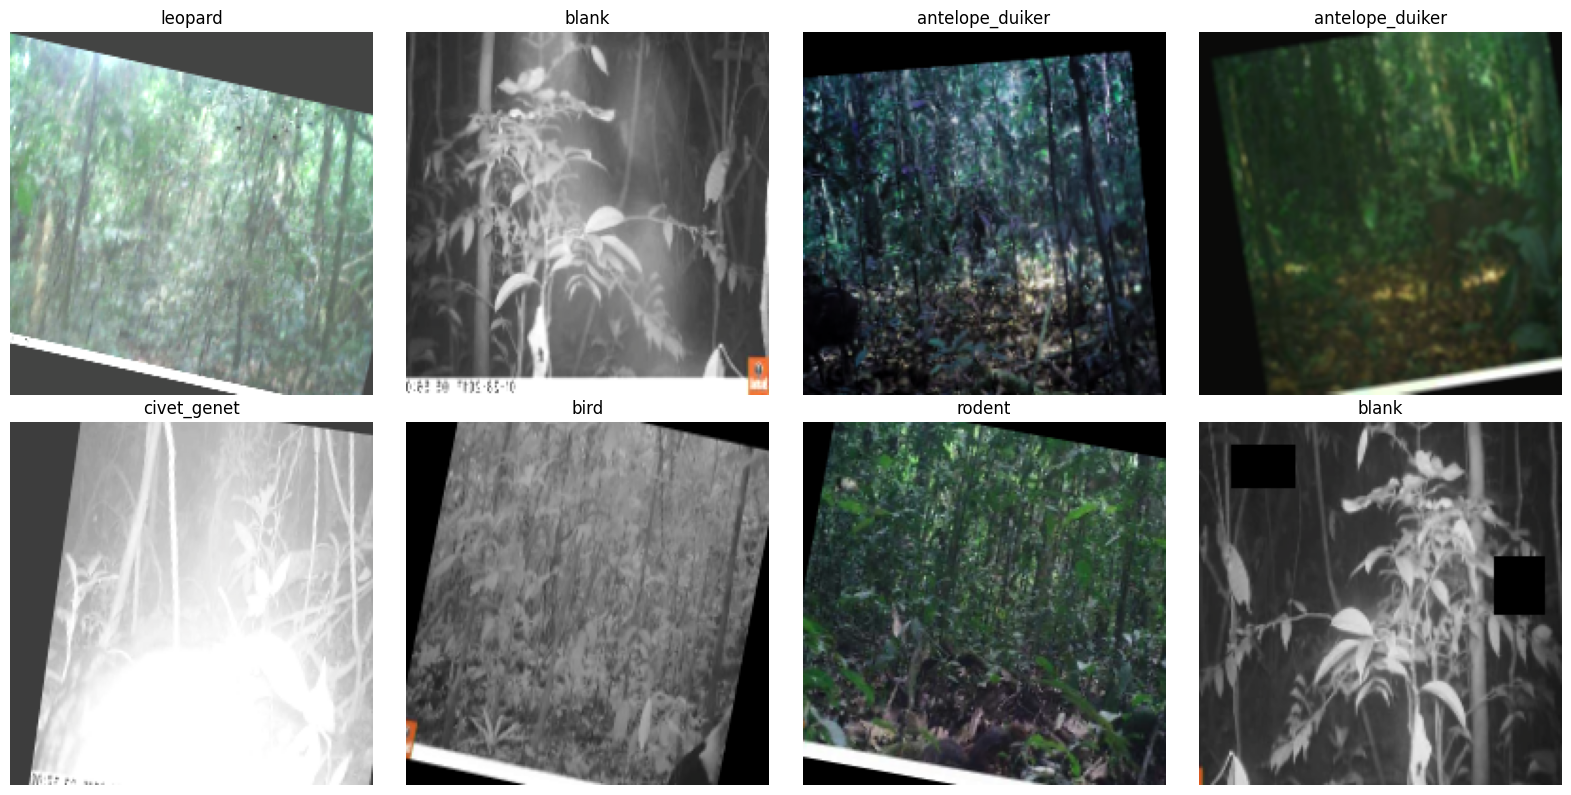

 Batch visualization saved

TESTING DATALOADERS

 Testing training DataLoader...
 Batch loaded successfully
   • Image shape: torch.Size([32, 3, 192, 192])
   • Labels shape: torch.Size([32, 8])
   • Image IDs: 32

 Testing validation DataLoader...
 Batch loaded successfully
   • Image shape: torch.Size([32, 3, 192, 192])
   • Labels shape: torch.Size([32, 8])

 Verifying label integrity...
 All labels sum to 1.0: True

DATALOADER SETUP COMPLETE!

 Configuration saved to: outputs/dataloader_config.json

 Summary:
   • Image size: 192x192
   • Batch size: 32
   • Training batches per epoch: 422
   • Validation batches per epoch: 93
   • Classes: 8
   Train samples: 13518
   Val samples: 2970
422 93


In [9]:
from pathlib import Path
from pytorch_dataset import create_dataloaders

# match your config
BATCH_SIZE = 32
IMG_SIZE = 192
NUM_WORKERS = 0          # on macOS/MPS, start with 0 (avoid spawn pain)

train_loader, val_loader = create_dataloaders(
    train_csv_path="outputs/train_split.csv",
    val_csv_path="outputs/val_split.csv",
    data_dir=Path("data"),
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    img_size=IMG_SIZE,
)

print(len(train_loader), len(val_loader))

In [10]:

# Create trainer (assumes train_loader and val_loader exist from previous notebook)
trainer = WildlifeTrainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    device=DEVICE,
    experiment_name=EXPERIMENT_NAME
)

# Train the model
history = trainer.train(
    num_epochs=NUM_EPOCHS,
    early_stopping_patience=EARLY_STOPPING_PATIENCE
)

 Trainer initialized: resnet50_baseline_0121_1154

TRAINING: resnet50_baseline_0121_1154


Epoch 1 [Train]:   0%|          | 0/422 [00:00<?, ?it/s]

Epoch 1 [Val]  :   0%|          | 0/93 [00:00<?, ?it/s]


Epoch 1/12 (1177.4s)
  Train - Loss: 0.3400, Acc: 0.3378
  Val   - Loss: 0.3211, Acc: 0.3444, LogLoss: 1.6933
  LR: 0.001000
  New best model! (LogLoss: 1.6933)
--------------------------------------------------------------------------------


Epoch 2 [Train]:   0%|          | 0/422 [00:00<?, ?it/s]

Epoch 2 [Val]  :   0%|          | 0/93 [00:00<?, ?it/s]


Epoch 2/12 (3605.2s)
  Train - Loss: 0.3162, Acc: 0.4003
  Val   - Loss: 0.3087, Acc: 0.4017, LogLoss: 1.6188
  LR: 0.001000
  New best model! (LogLoss: 1.6188)
--------------------------------------------------------------------------------


Epoch 3 [Train]:   0%|          | 0/422 [00:00<?, ?it/s]

Epoch 3 [Val]  :   0%|          | 0/93 [00:00<?, ?it/s]


Epoch 3/12 (1057.5s)
  Train - Loss: 0.3149, Acc: 0.3991
  Val   - Loss: 0.3212, Acc: 0.3845, LogLoss: 1.7158
  LR: 0.001000
  No improvement (1/6)
--------------------------------------------------------------------------------


Epoch 4 [Train]:   0%|          | 0/422 [00:00<?, ?it/s]

Epoch 4 [Val]  :   0%|          | 0/93 [00:00<?, ?it/s]


Epoch 4/12 (1093.6s)
  Train - Loss: 0.3128, Acc: 0.4131
  Val   - Loss: 0.3309, Acc: 0.3279, LogLoss: 1.7482
  LR: 0.001000
  No improvement (2/6)
--------------------------------------------------------------------------------


Epoch 5 [Train]:   0%|          | 0/422 [00:00<?, ?it/s]

Epoch 5 [Val]  :   0%|          | 0/93 [00:00<?, ?it/s]


Epoch 5/12 (1096.0s)
  Train - Loss: 0.3172, Acc: 0.4030
  Val   - Loss: 0.3301, Acc: 0.3566, LogLoss: 1.7818
  LR: 0.001000
  No improvement (3/6)
--------------------------------------------------------------------------------


Epoch 6 [Train]:   0%|          | 0/422 [00:00<?, ?it/s]

Epoch 6 [Val]  :   0%|          | 0/93 [00:00<?, ?it/s]


Epoch 6/12 (1108.0s)
  Train - Loss: 0.3184, Acc: 0.4067
  Val   - Loss: 0.3178, Acc: 0.3519, LogLoss: 1.7228
  LR: 0.001000
  No improvement (4/6)
--------------------------------------------------------------------------------


Epoch 7 [Train]:   0%|          | 0/422 [00:00<?, ?it/s]

Epoch 7 [Val]  :   0%|          | 0/93 [00:00<?, ?it/s]


Epoch 7/12 (1144.8s)
  Train - Loss: 0.3099, Acc: 0.4137
  Val   - Loss: 0.3267, Acc: 0.3747, LogLoss: 1.7448
  LR: 0.000500
  No improvement (5/6)
--------------------------------------------------------------------------------


Epoch 8 [Train]:   0%|          | 0/422 [00:00<?, ?it/s]

Epoch 8 [Val]  :   0%|          | 0/93 [00:00<?, ?it/s]


Epoch 8/12 (1162.8s)
  Train - Loss: 0.3067, Acc: 0.4231
  Val   - Loss: 0.3175, Acc: 0.3916, LogLoss: 1.6837
  LR: 0.000500
  No improvement (6/6)

 Early stopping at epoch 8
   Best: epoch 2 (LogLoss: 1.6188)

TRAINING COMPLETE
Total time: 190.8 minutes
Best epoch: 2
Best validation LogLoss: 1.6188


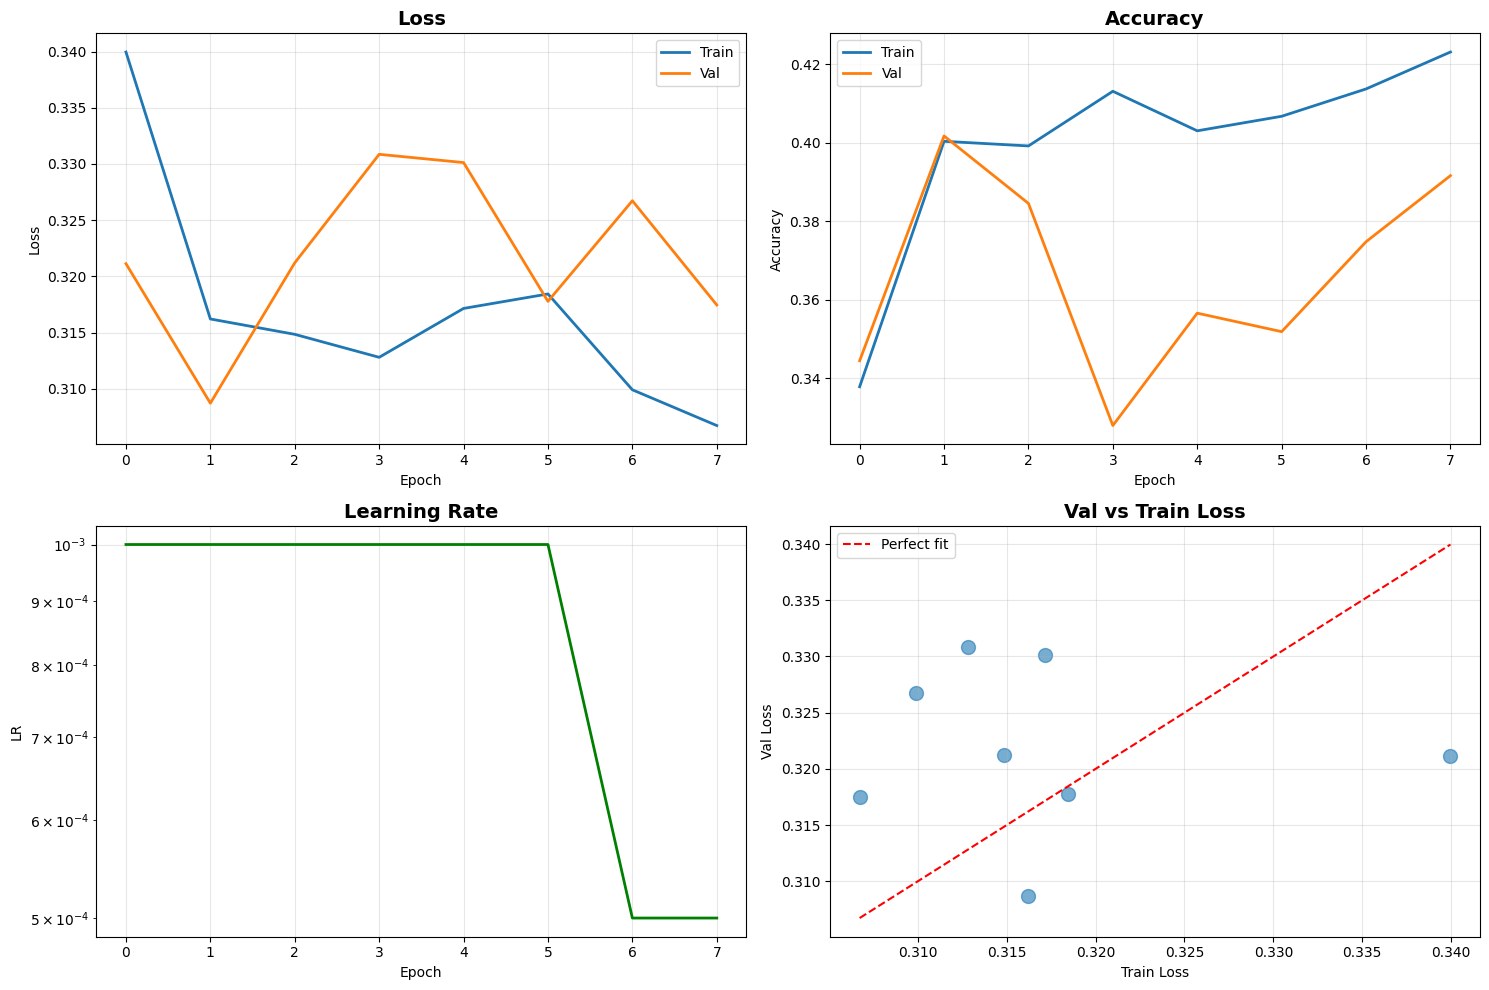

In [11]:
def plot_training_history(history):
    """Plot training curves"""
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Loss
    axes[0, 0].plot(history['train_loss'], label='Train', linewidth=2)
    axes[0, 0].plot(history['val_loss'], label='Val', linewidth=2)
    axes[0, 0].set_title('Loss', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(alpha=0.3)
    
    # Accuracy
    axes[0, 1].plot(history['train_acc'], label='Train', linewidth=2)
    axes[0, 1].plot(history['val_acc'], label='Val', linewidth=2)
    axes[0, 1].set_title('Accuracy', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].legend()
    axes[0, 1].grid(alpha=0.3)
    
    # Learning Rate
    axes[1, 0].plot(history['lr'], linewidth=2, color='green')
    axes[1, 0].set_title('Learning Rate', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('LR')
    axes[1, 0].set_yscale('log')
    axes[1, 0].grid(alpha=0.3)
    
    # Val Loss vs Train Loss
    axes[1, 1].scatter(history['train_loss'], history['val_loss'], alpha=0.6, s=100)
    axes[1, 1].plot([min(history['train_loss']), max(history['train_loss'])],
                    [min(history['train_loss']), max(history['train_loss'])],
                    'r--', label='Perfect fit')
    axes[1, 1].set_title('Val vs Train Loss', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Train Loss')
    axes[1, 1].set_ylabel('Val Loss')
    axes[1, 1].legend()
    axes[1, 1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'visualizations' / f'{EXPERIMENT_NAME}_history.png', dpi=300)
    plt.show()

plot_training_history(history)

In [12]:
# Create summary
summary = {
    'experiment_name': EXPERIMENT_NAME,
    'model_type': 'resnet50',
    'num_epochs': len(history['train_loss']),
    'best_epoch': trainer.best_epoch,
    'best_val_log_loss': float(trainer.best_val_loss),
    'final_train_loss': float(history['train_loss'][-1]),
    'final_val_loss': float(history['val_loss'][-1]),
    'final_train_acc': float(history['train_acc'][-1]),
    'final_val_acc': float(history['val_acc'][-1]),
    'config': {
        'batch_size': train_loader.batch_size,
        'img_size': 224,
        'optimizer': 'AdamW',
        'initial_lr': 1e-3,
        'weight_decay': 1e-4,
        'scheduler': 'ReduceLROnPlateau'
    }
}

# Save summary
with open(OUTPUT_DIR / f'{EXPERIMENT_NAME}_summary.json', 'w') as f:
    json.dump(summary, f, indent=2)

# Save history
with open(OUTPUT_DIR / f'{EXPERIMENT_NAME}_history.json', 'w') as f:
    json.dump(history, f, indent=2)

print(" Summary saved")
print(f"\nBest Model: {MODELS_DIR / f'{EXPERIMENT_NAME}_best.pth'}")
print(f"Best Val LogLoss: {trainer.best_val_loss:.4f} (Epoch {trainer.best_epoch})")

 Summary saved

Best Model: outputs/models/resnet50_baseline_0121_1154_best.pth
Best Val LogLoss: 1.6188 (Epoch 2)


In [13]:
# Load TensorBoard extension in Jupyter
%load_ext tensorboard

# Launch TensorBoard
%tensorboard --logdir {LOGS_DIR}

In [14]:
print("="*80)
print("TRAINING COMPLETE!")
print("="*80)

print(f"\n Results:")
print(f"   Experiment: {EXPERIMENT_NAME}")
print(f"   Best Epoch: {trainer.best_epoch}")
print(f"   Best Val LogLoss: {trainer.best_val_loss:.4f}")
print(f"   Final Train Loss: {history['train_loss'][-1]:.4f}")
print(f"   Final Val Loss: {history['val_loss'][-1]:.4f}")

print(f"\n Saved Files:")
print(f"   • Best model: {MODELS_DIR / f'{EXPERIMENT_NAME}_best.pth'}")
print(f"   • Final model: {MODELS_DIR / f'{EXPERIMENT_NAME}_final.pth'}")
print(f"   • Training history: {OUTPUT_DIR / f'{EXPERIMENT_NAME}_history.json'}")
print(f"   • Summary: {OUTPUT_DIR / f'{EXPERIMENT_NAME}_summary.json'}")

TRAINING COMPLETE!

 Results:
   Experiment: resnet50_baseline_0121_1154
   Best Epoch: 2
   Best Val LogLoss: 1.6188
   Final Train Loss: 0.3067
   Final Val Loss: 0.3175

 Saved Files:
   • Best model: outputs/models/resnet50_baseline_0121_1154_best.pth
   • Final model: outputs/models/resnet50_baseline_0121_1154_final.pth
   • Training history: outputs/resnet50_baseline_0121_1154_history.json
   • Summary: outputs/resnet50_baseline_0121_1154_summary.json
